<a href="https://colab.research.google.com/github/yiboxu20/MachineLearning/blob/main/Resources/Module1/regression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression part 2
- LASSO

- Robust linear regression

- Big data situation

## Least Absolute Shrinkage and Selection Operator (LASSO)

In ridge regression, we encourage the parameters to be small, and hence prevents overfitting. However, sometimes we want the parameters to not just be small, but to
be exactly zero, i.e, $\hat{\mathbf{w}}$ to be sparse. In other words, we want to minimize the **L0-norm**,
$$ \|\mathbf{w}\|_0=\sum_{i=1}^d\mathbb{1}(|w_i|>0)$$
It is useful since we can perform the feature selection, i.e, if the weight is 0, we can ignore the corresponding feature.



The lost function is defined as
$$\text{LOSS}(\mathbf{w})=\|\mathbf{X}\mathbf{w} - \mathbf{y}\|_2^2 +\lambda \|\mathbf{w}\|_1  $$

- add a penalty which penalizes the sum of absolute values, $\|\mathbf{w}\|_1$.

- for proper choice of penalty parameter $\lambda$, many coefficients $w_i$ are exactly zero under LASSO. It is called **$l_1$-regularization**.

## Why $l_1$ regularization yield sparse solution?
We plot the contours of the loss functions, as well as the contours of the $l_1$ and $l_2$ constraint surface. From the theory of constrained optimization, we know
that the optimal solution occurs at the point where the lowest level set of the objective function
intersects the constraint surface

In [1]:
%pylab inline
from IPython.display import Image
import numpy.linalg as LA
Image(url='https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/lasso.png?raw=true',width=600)

Populating the interactive namespace from numpy and matplotlib


In [2]:
Image(url='https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/lasso1.png?raw=true',width=600)

In [3]:
Image(url='https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/lasso2.png?raw=true',width=600)

For $q<1$, we can get even sparser solutions, but the problem becomes non-convex. So $l_1$-norm is the tightest convex relaxation of $l_0$-norm.  

## Solve LASSO Numerically

Unlike the previous models, no closed-form solution exists due to the fact that the loss function is no longer continuously differentiable (non-smooth absolute component). We will use **Pathwise Coordinate Descent** algorithm. Basic idea of this algorithm is to optimize a parameter at a time holding all other parameters constant. We can either cycle through
the coordinates in a deterministic fashion, or we can sample them at random. This method is particularly appealing if each one-dimensional optimization problem can be solved
analytically. This is known as the shooting algorithm. The gradient on the coordiant $w_d$,

\begin{align}
\frac{\partial}{\partial w_d} \text{LOSS}(\mathbf{w})&=\underbrace{\|\mathbf{X}_{:,d}\|_2^2}_{a_d}w_d-\underbrace{\mathbf{X}^\top_{:,d}(\mathbf{y}-\mathbf{X}_{:,-d}\mathbf{w}_{-d})}_{c_d}+\lambda \frac{\partial}{\partial w_d}\|\mathbf{w}\|_1 \\
&=\begin{cases} a_dw_d-c_d-\lambda & \text{if } w_d< 0  \\
        a_dw_d-c_d+\lambda & \text{if } w_d>0     \\
        [-c_d-\lambda, -c_d+\lambda] &  \text{if } w_d=0
 \end{cases}
\end{align}

where $\mathbf{w}_{-d}$ is $\mathbf{w}$ without component $d$ and similarly $\mathbf{X}_{:,-d}$ is the data matrix $\mathbf{X}$ without component $d$. We see that $c_d$ is proportional to the correlation between $d$’th column of features $\mathbf{X}_{:,d}$ and the
residual error obtained by predicting using all the other features, $\mathbf{r}_{-d}= \mathbf{y}-\mathbf{X}_{:,-d}\mathbf{w}_{-d}$. Hence the
magnitude of $c_d$ is an indication of how relevant feature $d$ is for predicting $\mathbf{y}$, relative to the other
features and the current parameters.


So the solution of the gradient being zero depends on $c_d$,
\begin{align}
\hat{w}_d(c_d)&= \begin{cases}(c_d+\lambda)/a_d & \text{if } c_d<-\lambda \\
0 & \text{if } \lambda>c_d>-\lambda  \\
(c_d-\lambda)/a_d & \text{if } c_d>\lambda  \end{cases} \\
&= \text{sign}\left(\frac{c_d}{a_d}\right)\max\left(\left|\frac{c_d}{a_d}\right|-\frac{\lambda}{a_d},0\right) \\
&= \text{SoftThreshold}(\frac{c_d}{a_d},\frac{\lambda}{a_d})
\end{align}
This is called **soft thresholding**. We plot the solution as follows. The dotted black line is the line $w_d = c_d/a_d$. corresponding to the least squares fit. The solid red line, which represents the regularized
estimate $\hat{w}_d$, shifts the dotted line down (or up) by $\lambda$, except when $-\lambda\le c_d\le \lambda$, in which case it sets $\hat{w}_d=0$.




### Debiasing
lasso is a biased estimator!

A simple solution to the biased estimate problem, known as debiasing, is to use a two-stage
estimation process: we first estimate the support of the weight vector (i.e., identify which elements
are non-zero) using lasso; we then re-estimate the chosen coefficients using least squares.

In [4]:
Image(url='https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/soft_threshold.png?raw=true',width=400)

In [5]:
import builtins
def lasso(X, y, l1, tol=1e-6):

  """The Lasso Regression model
      Pathwise coordinate descent with co-variance updates is applied.

      X - NumPy matrix, size (N, d), of standardized numerical predictors, note the first column is ones.
      y - NumPy array, length N, of numerical response.
      l1 - L1 penalty tuning parameter (positive scalar)
      tol - Coordinate Descent convergence tolerance (exited if change < tol)

  """
  m, n      = np.shape(X)
  q, r      = linalg.qr(X);
  w_s       = linalg.solve(r, q.T.dot(y))
  # w_s       = zeros(n)
  # w_s       = ones(n)
  iter   = 0
  a = np.sum(X**2, axis=0)
  while True:
      w_star = w_s.copy()
      for j in range(n):
        # a_j     = LA.norm(X[:, j])**2
        # index   = arange(n)
        # index_d = delete(index, j)
        # c_j     = np.dot(X[:,j].T, y-np.dot(X[:,index_d],w_s[index_d]))
        # update  = c_j/a_j
        # w_s[j]  = np.sign(update) * max(abs(update) - l1/a_j, 0)

        # Calculate partial residual without j-th feature
        # r_j = y- X.dot(w_s) + X[:, j] * w_s[j]
        # c_j = X[:, j].dot(r_j)

        # Calculate partial residual without j-th feature
        c_j = X[:, j].dot(y- X.dot(w_s)) + a[j] * w_s[j]

        w_s[j] = np.sign(c_j) * builtins.max(abs(c_j) - l1, 0.0) / a[j]

      iter += 1
      # if iter%2000 == 0:
      #   print('Iteration ', iter)
      #   print(w_s)
      if np.all(abs(w_s - w_star) < tol):
        print('Number of iteration is ', iter)
        break

      if iter > 100000:
        print('Reached maximum iterations without convergence ', iter)
        break

  return w_s


[  9.86810958 -20.83950897   5.92929849  -0.07250649  -0.05649201]


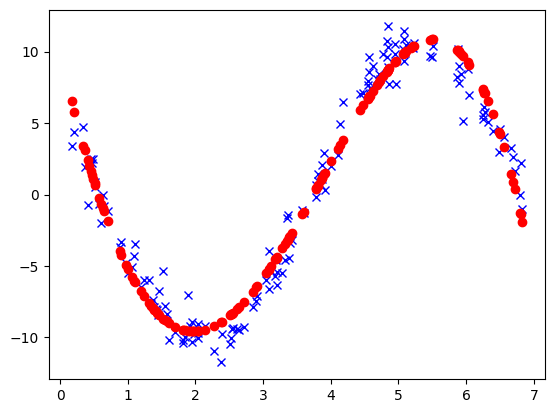

In [6]:
random.seed(3)

# generate sample with error
x = 7 * random.rand(150) # between 0 and 7
e = 1 * random.randn(x.size) # noise
y = 10*cos(x+1) + e;

# use fourth order polynomial again
X4 = np.ones((x.size,5));
X4[:,1] = x # partials wrt. w1
X4[:,2] = x**2 # wrt. w2
X4[:,3] = x**3 # wrt. w3
X4[:,4] = x**4 # wrt. w4

# lets look at these coefficient
q, r = linalg.qr(X4);
w4    = linalg.solve(r, q.T.dot(y))
print(w4)
yHat4   = X4.dot(w4)

plot(x,y,'bx');
plot(x,yHat4,'ro');

def RSS(y_residue):
  return 1/2 * np.sum(y_residue**2)


RSS for fourth order is 34.00317174065676


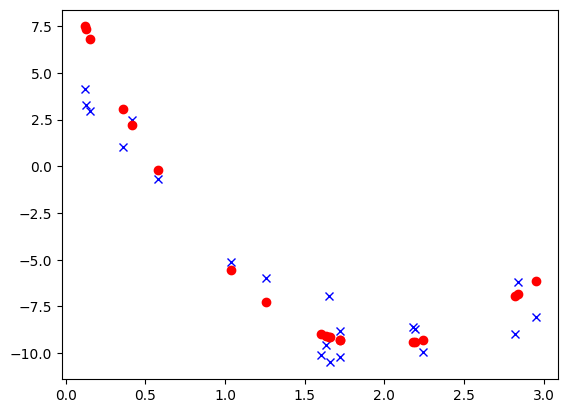

In [7]:
# Let's validate on test data
x_test = 3 * random.rand(20)+0 # between 0 and 3
e = 1 * random.randn(x_test.size) # noise
y_test = 10*cos(x_test+1) + e;

X4_test = np.ones((x_test.size,5));
X4_test[:,1] = x_test # partials wrt. w1
X4_test[:,2] = x_test**2 # wrt. w2
X4_test[:,3] = x_test**3 # wrt. w3
X4_test[:,4] = x_test**4 # wrt. w4

yHat4_test = X4_test.dot(w4)
print('RSS for fourth order is', RSS(y_test - yHat4_test))

plot(x_test,y_test,'bx');
plot(x_test,yHat4_test,'ro');

In [8]:
print(lasso(X4, y, 10, tol=1e-6))
#this weight you should is only for feature selection. You cannot use it as the final result.

Number of iteration is  25765
[ 3.79384845 -9.5261279  -0.          1.09686222 -0.13382775]


[  5.33113573 -10.664728     1.17893396  -0.1432244 ]
RSS without second order is  14.77966320693054


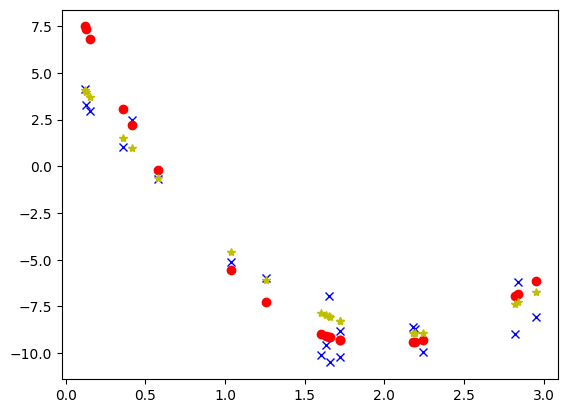

In [9]:
#to get unbiased results, you should use this updated feature to do LS.
X4_new = np.ones((x.size,4));
X4_new[:,1] = x # partials wrt. w1
X4_new[:,2] = x**3 # wrt. w3
X4_new[:,3] = x**4 # wrt. w4

# lets look at these coeffifients
q, r = linalg.qr(X4_new);
w4_new    = linalg.solve(r, q.T.dot(y))
print(w4_new)

X4_new_test = np.ones((x_test.size,4));
X4_new_test[:,1] = x_test # partials wrt. w1
X4_new_test[:,2] = x_test**3 # wrt. w3
X4_new_test[:,3] = x_test**4 # wrt. w4

yHat4_new_test = X4_new_test.dot(w4_new)
print('RSS without second order is ', RSS(y_test - yHat4_new_test))

plot(x_test,y_test,'bx');
plot(x_test,yHat4_test,'ro');
plot(x_test,yHat4_new_test,'y*');

## High dimensional data
Currently the number of feature is order of $10^1$. If the number of feature is order of $10^4$ or more, these algorithms (with QR or pseudo inverse) will be too expensive. The possible method is gradient descent. At each step $t$, compute $\mathbf{w}^t = \mathbf{w}^{t-1} - \eta \nabla \text{RSS}(\mathbf{w}^{t-1})$. For the learning rate $\eta$ is related to the Hessian of the function. For **strongly convex** $f$, this algorithm will converge to the minimizer, i,e, $\mathbf{x}_t\rightarrow x^*$, as $t\rightarrow +\infty$.

Gradient descent for linear regression,

- least square: $\mathbf{w}^t = \mathbf{w}^{t-1} - \eta \mathbf{X}^\top (\mathbf{X}\mathbf{w}^{t-1} -\mathbf{y}) $, where $\eta <\frac{1}{2\sigma_{\max}(\mathbf{X}^\top\mathbf{X})}$.

- ridge regression: $\mathbf{w}^t = (1-\eta \lambda)\mathbf{w}^{t-1} - \eta \mathbf{X}^\top (\mathbf{X}\mathbf{w}^{t-1} -\mathbf{y}) $, where $\eta <\frac{1}{2(\sigma_{\max}(\mathbf{X}^\top\mathbf{X})+\lambda))}$.

Let's calculate the computation time
- takes $O(\log(\frac{1}{\epsilon}))$ iterations to acheive an $\epsilon$-accuracy solution $\hat{\mathbf{w}}$ with $\|\hat{\mathbf{w}}-\mathbf{w}^*\|_2<\epsilon$.

- time complexity for $\epsilon$-accuracy solution: $O(\log(\frac{1}{\epsilon})*Nd)$




## Robust linear regression

Least squares tends to produce a linear
t that focused on trying to minimize these large errors { often due to outliers in dataset.)

In [10]:
Image(url='https://github.com/yiboxu20/MachineLearning/blob/main/Resources/images/least_abs_dev.png?raw=true',width=600)

The loss function is defined by the sum of absolute errors
$$\text{LOSS}(\mathbf{w})= \|\varepsilon\|_1=\|\mathbf{X}\mathbf{w} - \mathbf{y}\|_1$$ (leave it as HW)

Here are some optimization methods to minimize LOSS:

- Direction optimization, Using numpy optimization package. (Okay with small data set)

- coordinate gradient descent algorithm: $|\varepsilon_i|$ is non-differentiable at $\varepsilon_i = 0$, but sub-derivatives exist.

- Huber loss surrogate: a smooth surrogate of $|\varepsilon_i|$;  can be minimized via standard gradient descent. (smooth relaxation)

\begin{equation}
|\varepsilon_i| \approx L_\delta(\varepsilon_i) =
\begin{cases}
\frac{\varepsilon_i^2}{2\delta} & \mbox{if} \; |\varepsilon_i| \leq \delta \\
 |\varepsilon_i| - \frac{\delta}{2} & \mbox{if} \; |\varepsilon_i| > \delta
\end{cases}
\end{equation}

